In [91]:
# load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.io import arff
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import scipy.stats as stats

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# load data
from google.colab import drive
drive.mount('/content/drive')
bonemarrow, meta = arff.loadarff('/content/drive/MyDrive/Katie Programming Folder/bone-marrow.arff')
bonemarrow_df = pd.DataFrame(bonemarrow)

print(bonemarrow_df)
print(bonemarrow_df.info())
print(bonemarrow_df.describe())
print(bonemarrow_df.isnull().sum())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     donor_age donor_age_below_35 donor_ABO   donor_CMV  recipient_age  \
0    22.830137             b'yes'      b'A'  b'present'            9.6   
1    23.342466             b'yes'      b'B'   b'absent'            4.0   
2    26.394521             b'yes'      b'B'   b'absent'            6.6   
3    39.684932              b'no'      b'A'  b'present'           18.1   
4    33.358904             b'yes'      b'A'   b'absent'            1.3   
..         ...                ...       ...         ...            ...   
182  37.575342              b'no'      b'A'  b'present'           12.9   
183  22.895890             b'yes'      b'A'   b'absent'           13.9   
184  27.347945             b'yes'      b'A'  b'present'           10.4   
185  27.780822             b'yes'      b'A'   b'absent'            8.0   
186  55.553425              b'no'      b'A'  b'present'  

In [69]:
# Clean up data
# Decode byte string columns and clean the data
for col in bonemarrow_df.columns:
    if bonemarrow_df[col].dtype == 'object':
        bonemarrow_df[col] = bonemarrow_df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Drop NAs
bonemarrow_df = bonemarrow_df.replace('?', pd.NA)
bonemarrow_df = bonemarrow_df.dropna()

nan_columns = bonemarrow_df.isna().sum()
print(nan_columns)

print(bonemarrow_df.info())
print(bonemarrow_df.head())


donor_age                    0
donor_age_below_35           0
donor_ABO                    0
donor_CMV                    0
recipient_age                0
recipient_age_below_10       0
recipient_age_int            0
recipient_gender             0
recipient_body_mass          0
recipient_ABO                0
recipient_rh                 0
recipient_CMV                0
disease                      0
disease_group                0
gender_match                 0
ABO_match                    0
CMV_status                   0
HLA_match                    0
HLA_mismatch                 0
antigen                      0
allel                        0
HLA_group_1                  0
risk_group                   0
stem_cell_source             0
tx_post_relapse              0
CD34_x1e6_per_kg             0
CD3_x1e8_per_kg              0
CD3_to_CD34_ratio            0
ANC_recovery                 0
PLT_recovery                 0
acute_GvHD_II_III_IV         0
acute_GvHD_III_IV            0
time_to_

In [70]:
# Select numeric columns for correlation analysis
numeric_bonemarrow_df = bonemarrow_df.select_dtypes(include=[np.number])

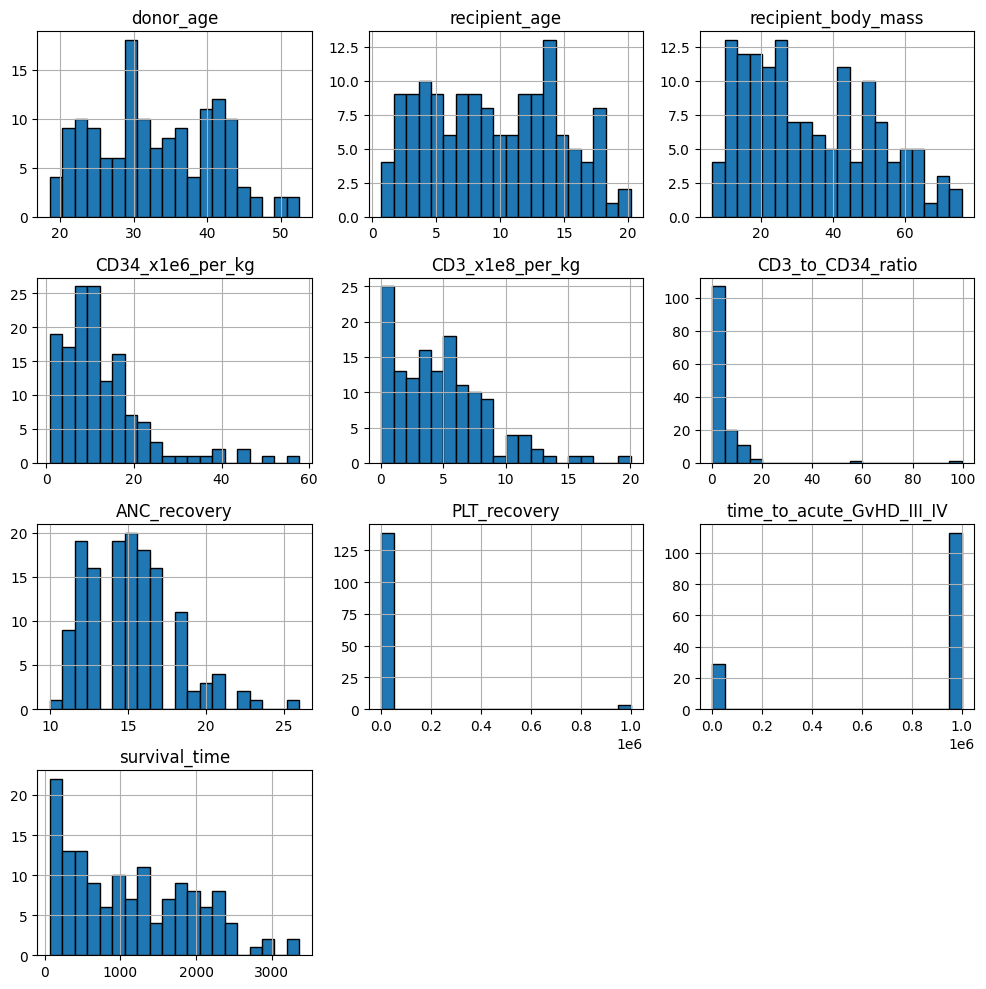

In [71]:
# Visualizing distributions of numeric features
numeric_bonemarrow_df.hist(figsize=(10, 10), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

In [72]:
# data transformations?
# Apply log10 transformation to the entire DataFrame
#numeric_bonemarrow_df_log10 = numeric_bonemarrow_df.apply(np.log10)

# If there are zeros or negative values in the DataFrame, you might want to handle them as log10 is undefined for such values.
# For example, you can replace zeros with a small positive value like 1e-10:
#numeric_bonemarrow_df = numeric_bonemarrow_df.replace(0, 1e-10).apply(np.log10)

# Check the transformed DataFrame
#print(numeric_bonemarrow_df.head())

In [73]:
# For the purposes of our analysis, we will remove outliers as they may significantly impact our data
# Function to remove outliers based on Z-score
def remove_outliers_z_score(df, threshold=3):
  z_scores = np.abs((df - df.mean()) / df.std())
  return df[(z_scores < threshold).all(axis=1)]

# Applying the function
numeric_bonemarrow_df = remove_outliers_z_score(numeric_bonemarrow_df)

# Display the cleaned DataFrame
print(numeric_bonemarrow_df)

# Applying the function
numeric_bonemarrow_df = remove_outliers_z_score(numeric_bonemarrow_df)

# Display the cleaned DataFrame
print(numeric_bonemarrow_df)


     donor_age  recipient_age  recipient_body_mass  CD34_x1e6_per_kg  \
0    22.830137            9.6                 35.0              7.20   
1    23.342466            4.0                 20.6              4.50   
2    26.394521            6.6                 23.4              7.94   
8    32.641096            7.9                 20.5             23.54   
9    28.783562            4.7                 16.5              7.69   
..         ...            ...                  ...               ...   
179  30.024658            7.5                 28.0              8.11   
182  37.575342           12.9                 44.0             11.08   
183  22.895890           13.9                 44.5              4.64   
184  27.347945           10.4                 33.0              7.73   
185  27.780822            8.0                 24.0             15.41   

     CD3_x1e8_per_kg  CD3_to_CD34_ratio  ANC_recovery  PLT_recovery  \
0               5.38           1.338760          19.0          5

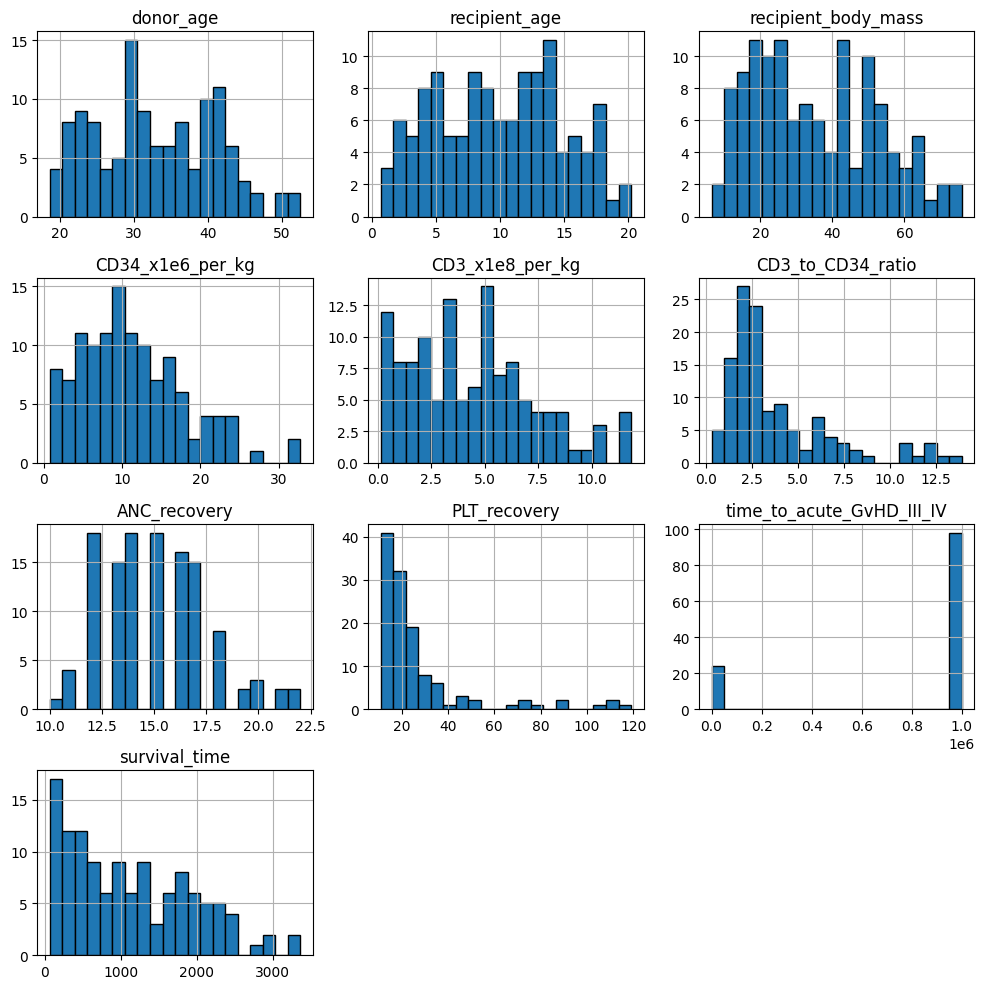

In [74]:
# Visualizing distributions of numeric features after outlier removal
numeric_bonemarrow_df.hist(figsize=(10, 10), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

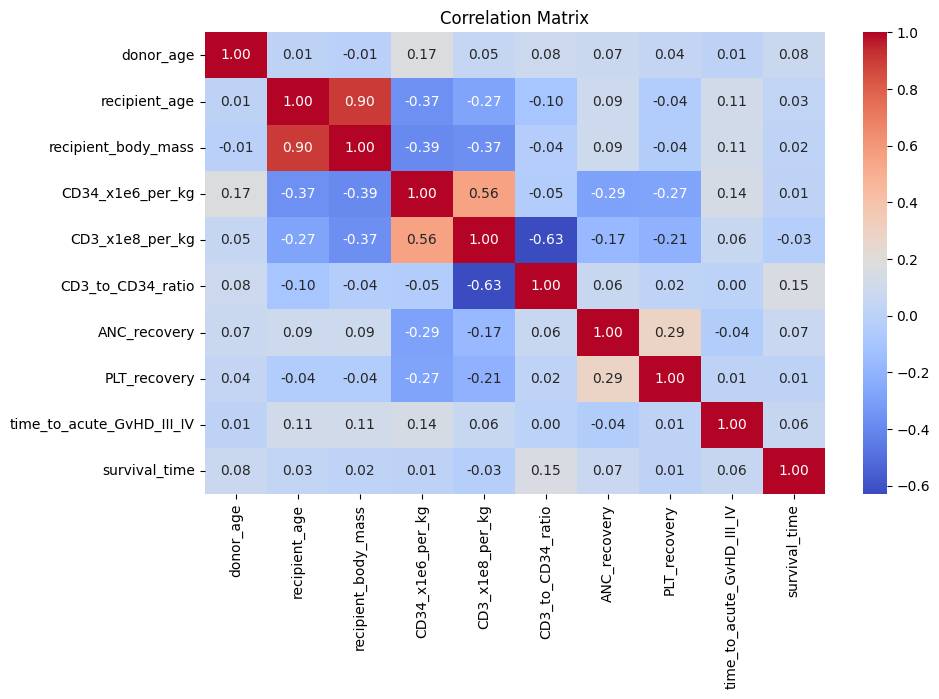

In [75]:
# Plotting correlations (for numeric variables)
plt.figure(figsize=(10, 6))

sns.heatmap(numeric_bonemarrow_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

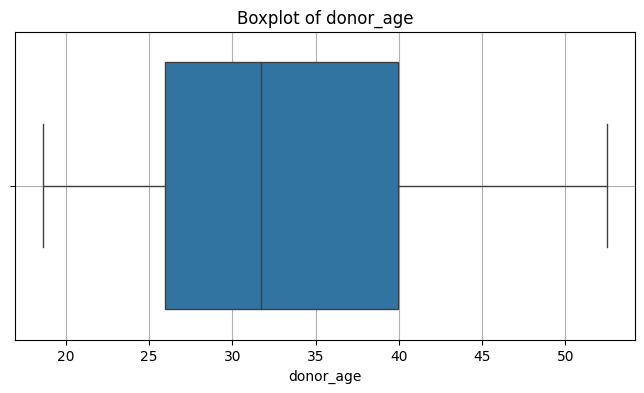

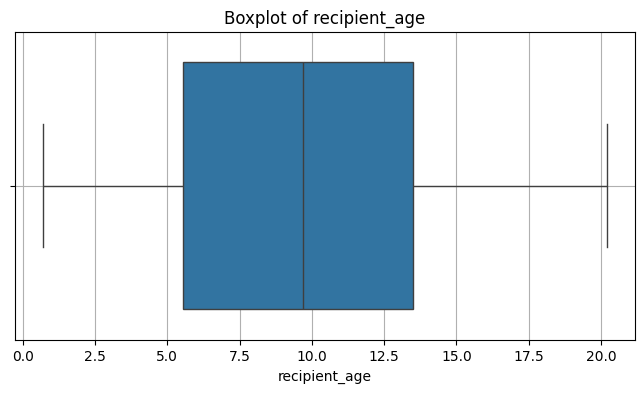

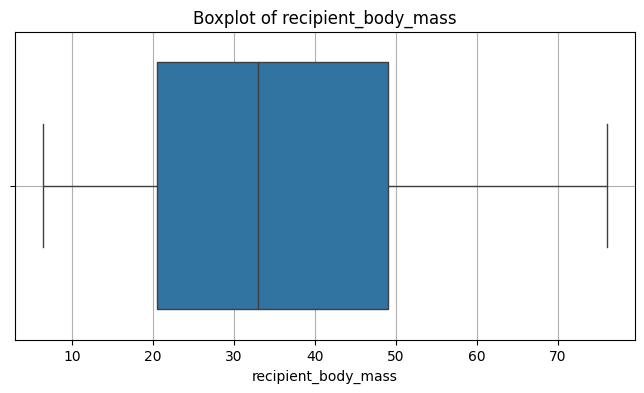

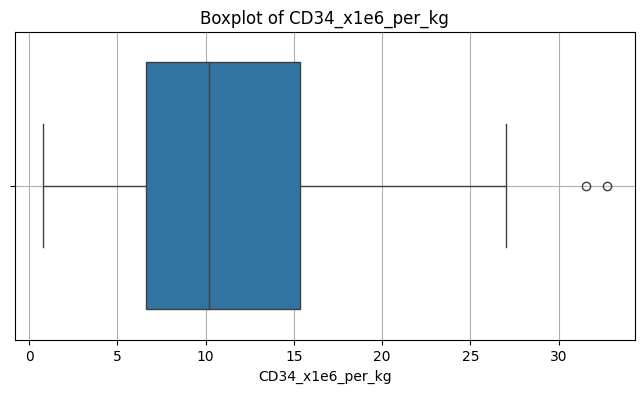

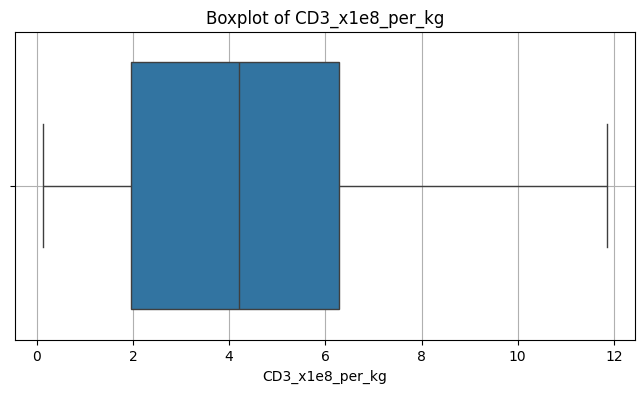

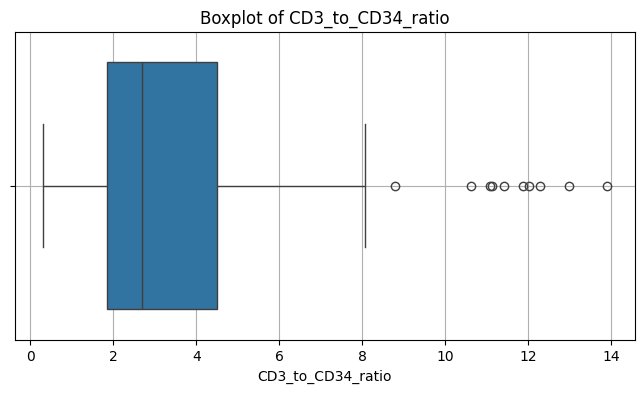

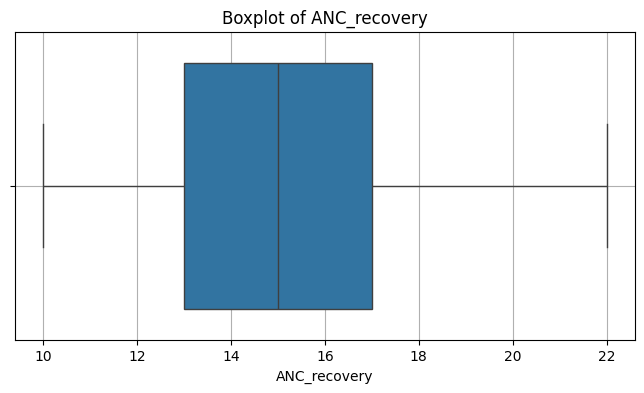

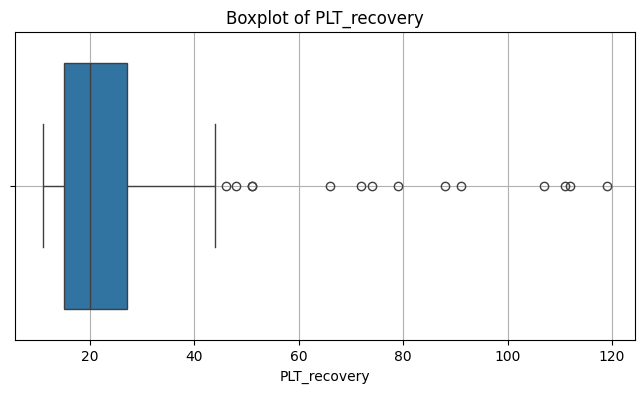

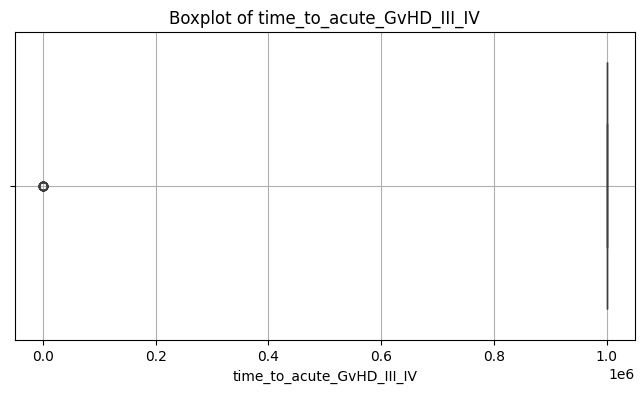

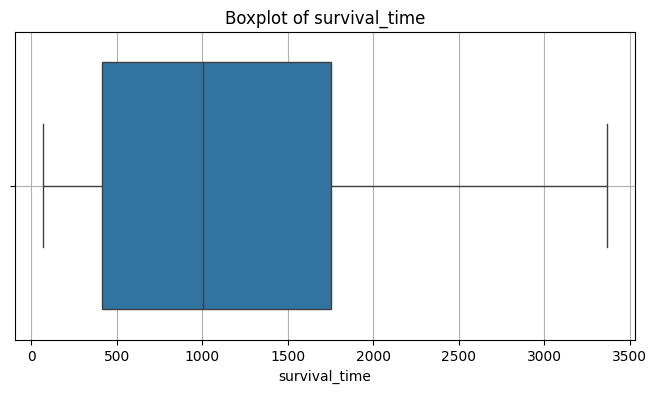

In [76]:
# Check if the dataframe is empty and has numeric columns
if not numeric_bonemarrow_df.empty:

    # Individual boxplots for each numeric feature (optional, for more detailed analysis)
    for col in numeric_bonemarrow_df.columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=numeric_bonemarrow_df[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.grid(True)
        plt.show()
else:
    print("The dataframe does not contain any numeric columns.")

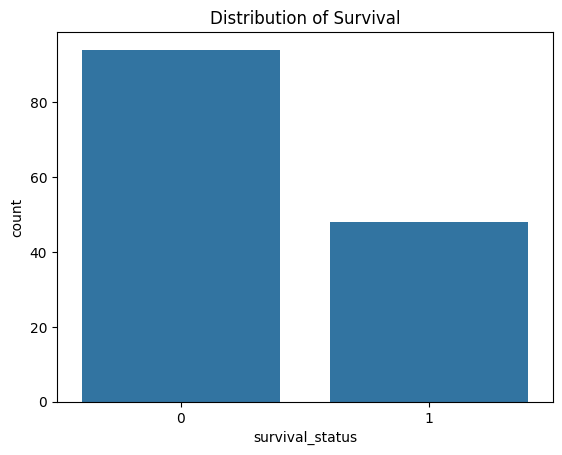

In [77]:
# Checking the distribution of the target variable (if there is one)
sns.countplot(x='survival_status', data=bonemarrow_df)
plt.title('Distribution of Survival')
plt.show()

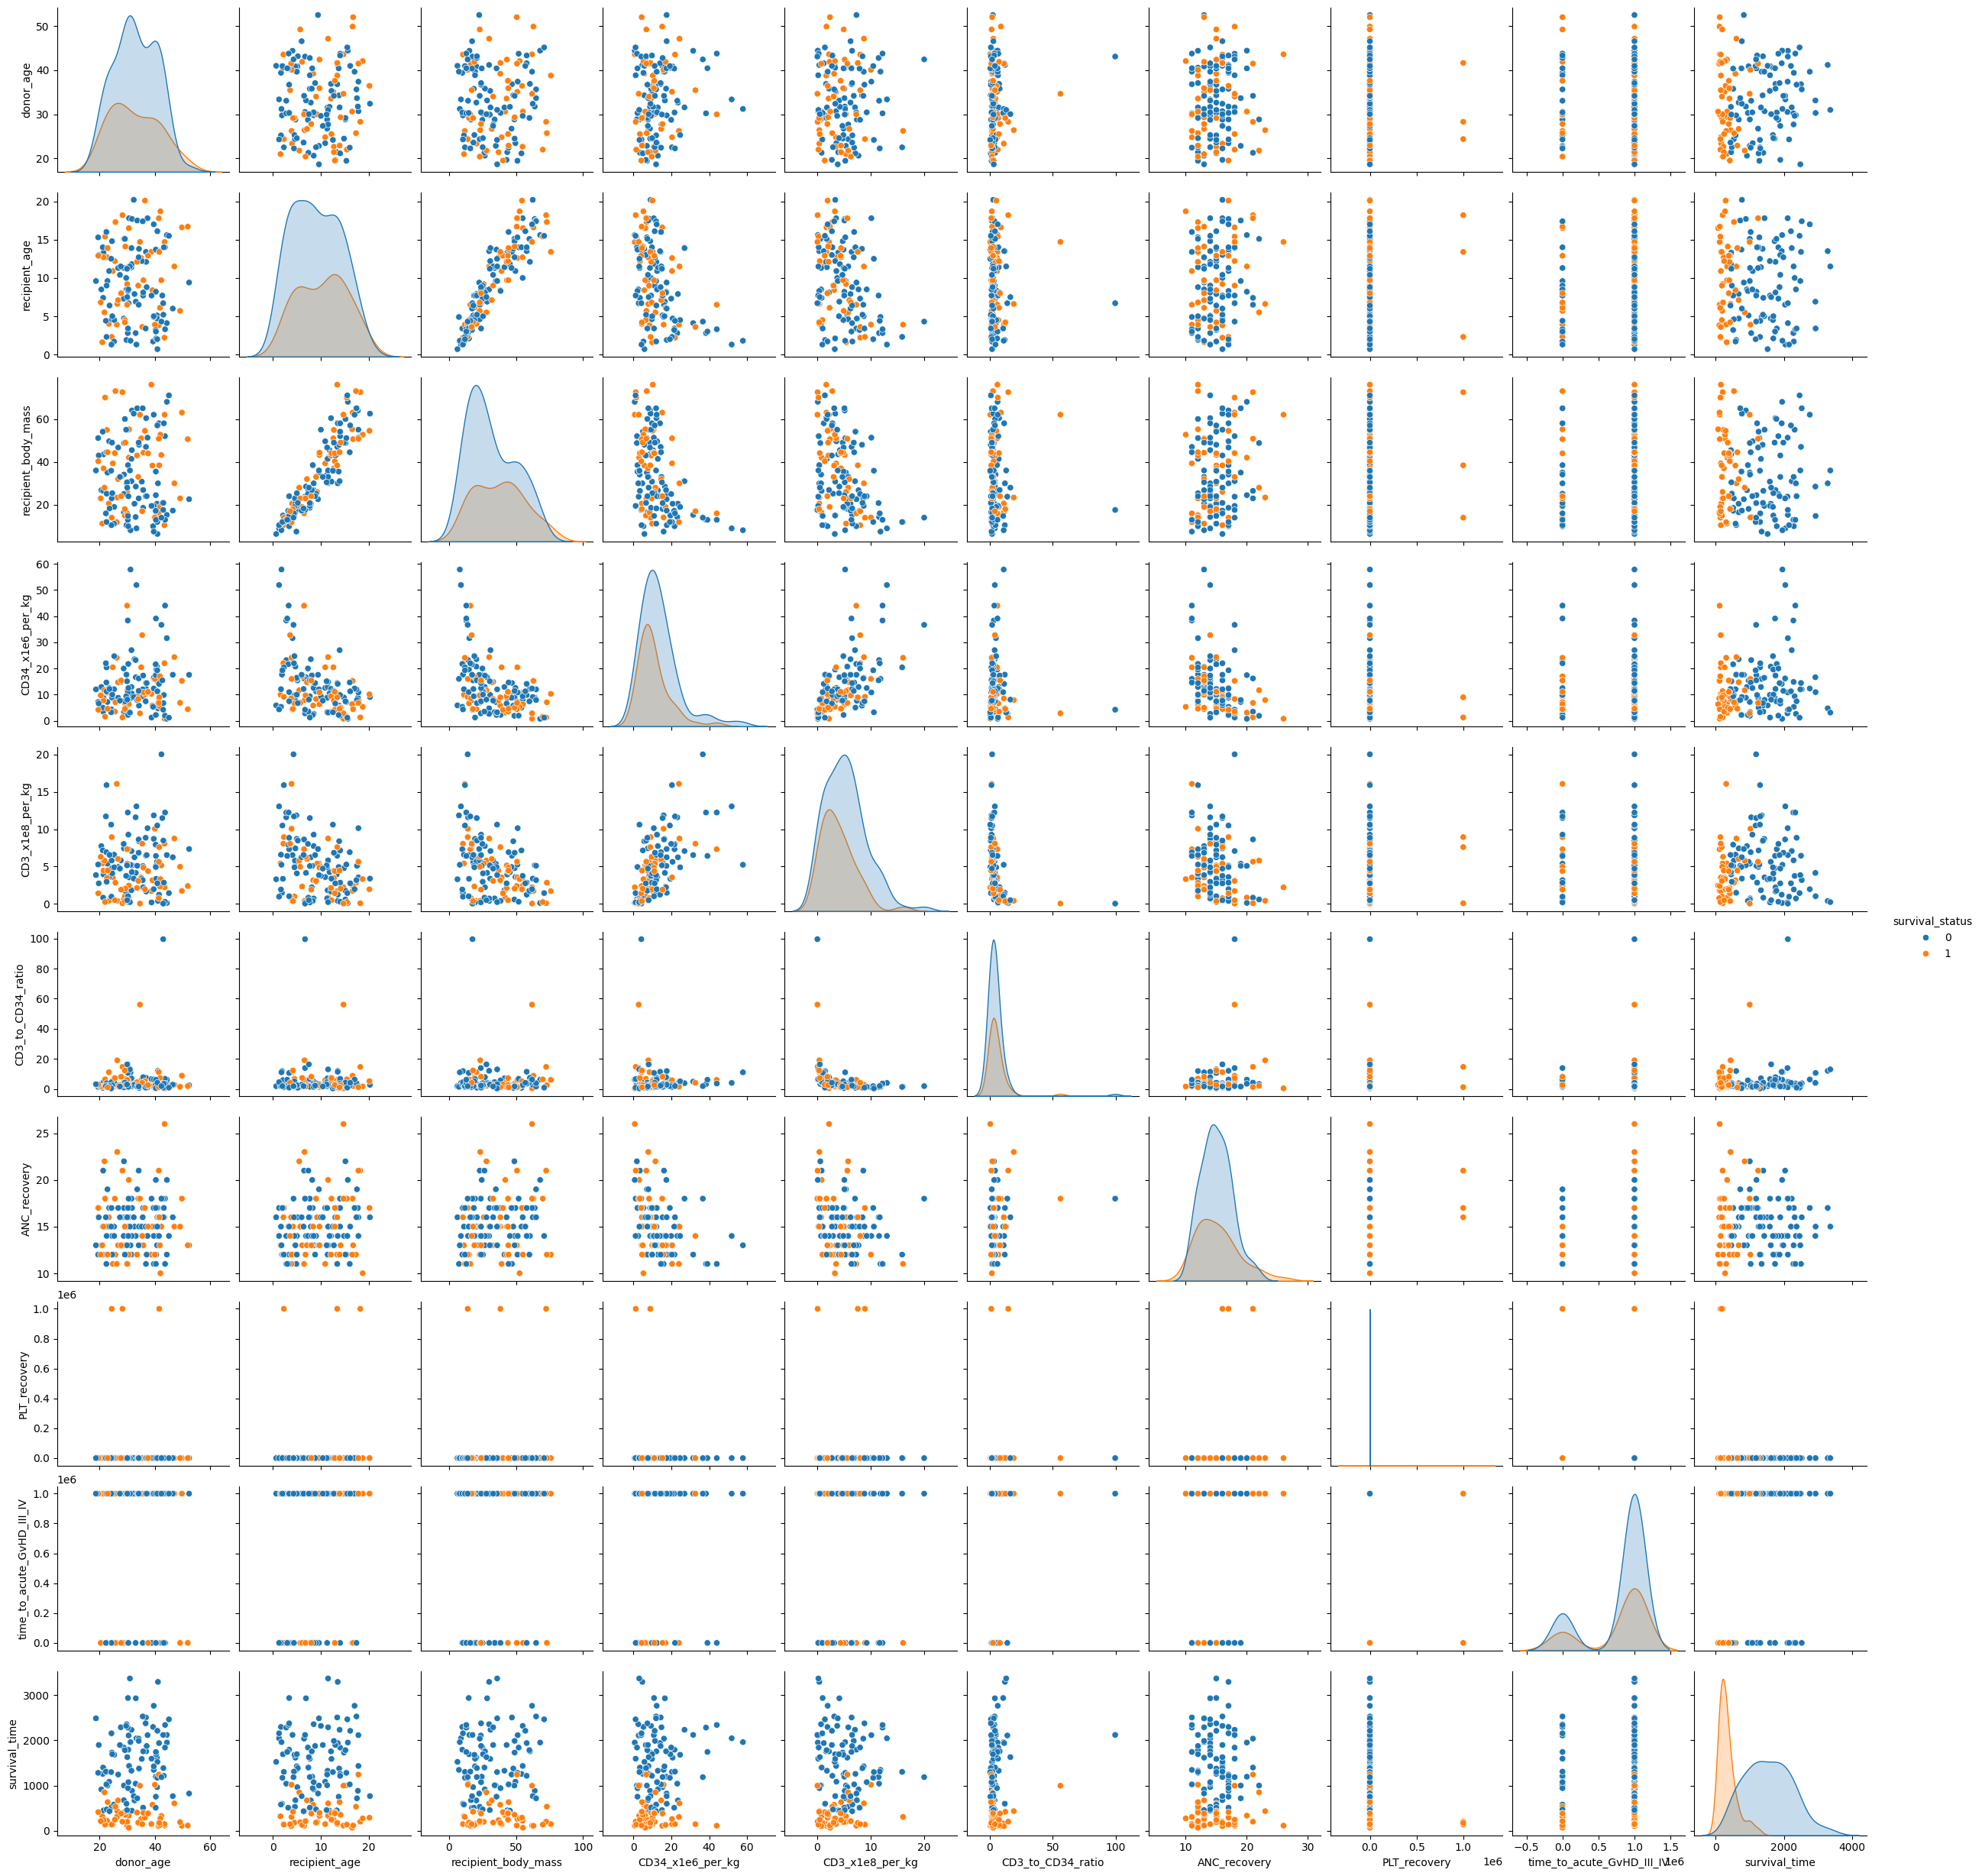

In [78]:
# Pairplot to visualize relationships between variables
sns.pairplot(bonemarrow_df, hue='survival_status', vars=numeric_bonemarrow_df.columns)
plt.show()

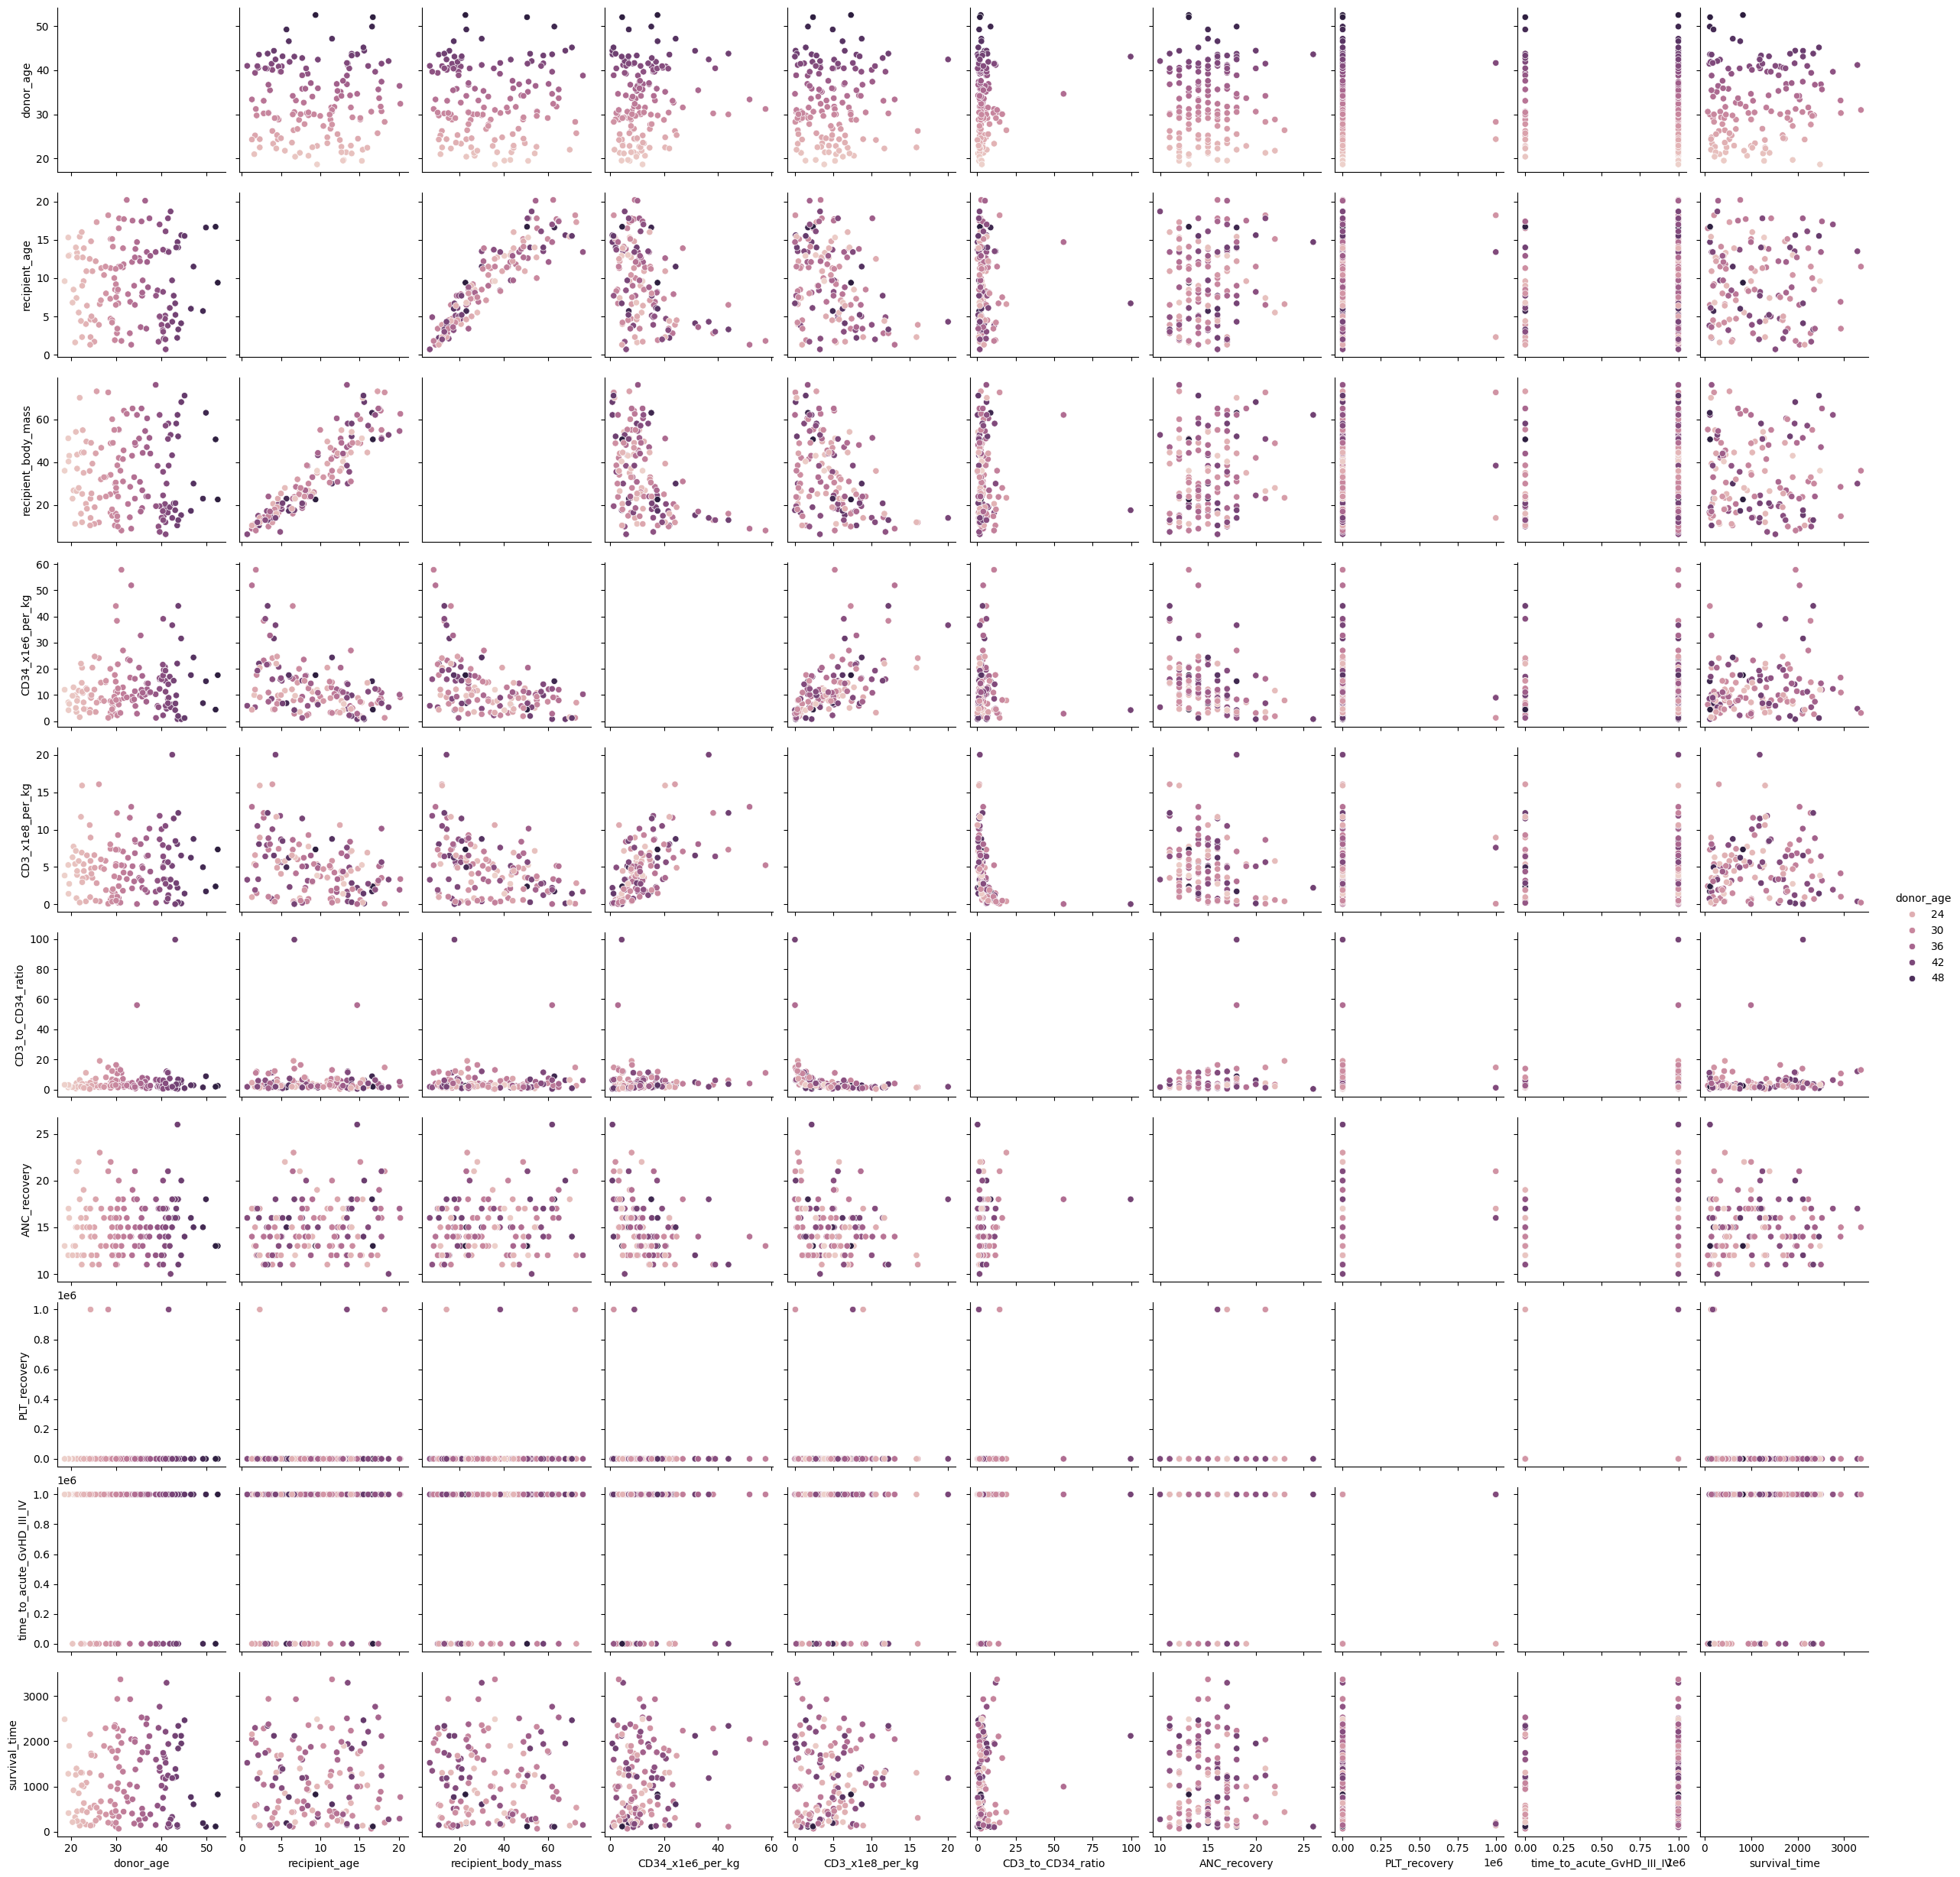

In [79]:
# Pairplot to visualize relationships between variables
sns.pairplot(bonemarrow_df, hue='donor_age', vars=numeric_bonemarrow_df.columns)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['donor_ABO' 'donor_CMV' 'recipient_age_int' 'recipient_gender'
 'recipient_ABO' 'recipient_rh' 'recipient_CMV' 'disease' 'disease_group'
 'gender_match' 'ABO_match' 'CMV_status' 'HLA_match' 'HLA_mismatch'
 'antigen' 'allel' 'HLA_group_1' 'risk_group' 'stem_cell_source'
 'survival_status']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter

Accuracy: 0.7586206896551724
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        25
           1       0.00      0.00      0.00         4

    accuracy                           0.76        29
   macro avg       0.42      0.44      0.43        29
weighted avg       0.73      0.76      0.74        29



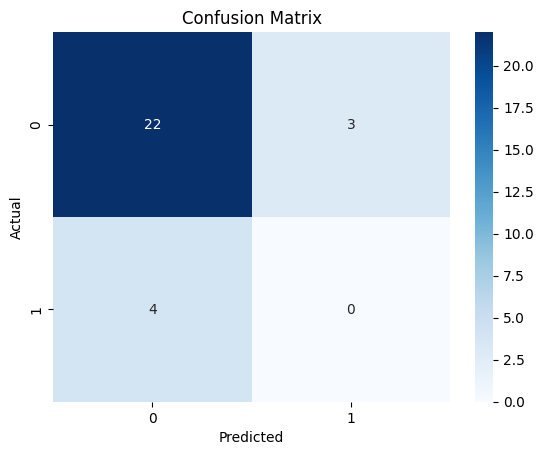

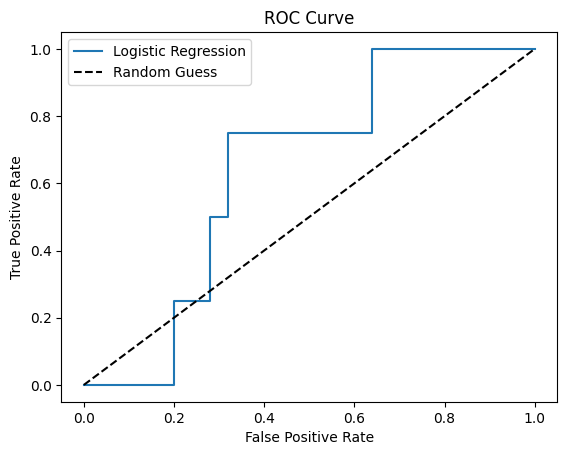

AUC Score: 0.64


In [95]:
# Logistic regression analysis
# Step 1: Define target variable and features
X = bonemarrow_df.drop('relapse', axis=1)
y = bonemarrow_df['relapse']

# Step 2: Convert 'yes' and 'no' in the target variable to 1 and 0 respectively
y = y.map({'yes': 1, 'no': 0})
# Convert 'yes' and 'no' to numerical values in all columns of X
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].map({'yes': 1, 'no': 0})

# Extra: Impute missing values using SimpleImputer
import numpy as np
from sklearn.impute import SimpleImputer

# Create an imputer to replace NaN with the mean of the column
imputer = SimpleImputer(strategy='median')  # We may change?

# Fit the imputer on the training data and transform both train and test data
X = imputer.fit_transform(X)

# Step 3: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=445)

# Step 4: Fit the logistic regression model
# Create an instance of the LogisticRegression class
log_reg = LogisticRegression()
# Fit the model to the training data
log_reg.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Step 6: Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Classification report: precision, recall, f1-score
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Predict probabilities for the positive class (1)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# AUC Score
auc_score = roc_auc_score(y_test, y_prob)
print(f'AUC Score: {auc_score}')